In [62]:
#################### Load Data from REDCap & validate timestamps ####################
# Import tokens and report structures
from constants import posts_token, all_posts, flagged_posts, participants_token, participants_table1
from functions import pull_redcap_report
import pandas as pd

# Load data
## Need all posts to calculate time on Facebook; flagged posts include PD relevant & irrelevant posts
print("Loading data from REDCap reports...")
participants = pull_redcap_report(participants_token, participants_table1)
posts = pull_redcap_report(posts_token, all_posts)
flagged_posts = pull_redcap_report(posts_token, flagged_posts)

# Select posts that were either automatically or manually classified as PD-relevant
pd_posts = flagged_posts[
    (flagged_posts["nb_classification"] == 1) | 
    (flagged_posts["manual_label_pd_relevant"] == 1)
]

# Convert timestamp and diagnosis date fields to datetime
posts['timestamp'] = pd.to_datetime(posts['timestamp'], errors='coerce')
pd_posts.loc[:, 'timestamp'] = pd.to_datetime(pd_posts['timestamp'], errors='coerce')  # Use .loc to avoid SettingWithCopyWarning
participants['diagnosis_date'] = pd.to_datetime(participants['diagnosis_date'], errors='coerce')
participants['carereceiver_dx_date'] = pd.to_datetime(participants['carereceiver_dx_date'], errors='coerce')

# Assign diagnosis group: if 'dx_type' is missing, the participant is a caregiver
participants['diagnosis_group'] = participants['dx_type'].fillna('Caregiver')
participants = participants.drop('dx_type', axis=1).copy()

# Create a filtered copy of PD-relevant posts that excludes those mentioning exercise
pd_posts_no_exercise = pd_posts[
    ~pd_posts['keyword_categories'].str.contains("exercise", case=False, na=False)
].copy()

Loading data from REDCap reports...


In [63]:
########################## Compute Facebook Activity Timelines ##########################

# Step 1: Calculate overall Facebook activity per participant
# Includes first post, last post, and total number of posts (not just PD-related)
participant_activity = posts.groupby('participant_id')['timestamp'].agg(['min', 'max', 'count']).reset_index()
participant_activity.rename(columns={
    'min': 'first_post',
    'max': 'last_post',
    'count': 'num_posts_overall'  # Total posts regardless of content
}, inplace=True)

# Total duration of Facebook activity
participant_activity['time_on_facebook'] = participant_activity['last_post'] - participant_activity['first_post']

# Step 2: Merge in diagnosis and demographic information
participant_activity = participant_activity.merge(
    participants[['record_id', 'diagnosis_group', 'diagnosis_date', 'carereceiver_dx_date', 'dob']],
    left_on='participant_id', right_on='record_id', how='left'
)

# Determine applicable diagnosis date
# Use carereceiver_dx_date for caregivers; otherwise use participant’s own diagnosis_date
participant_activity['dx_date'] = participant_activity.apply(
    lambda row: row['carereceiver_dx_date'] if row['diagnosis_group'] == 'Caregiver' else row['diagnosis_date'],
    axis=1
)

# Clean up: Drop columns no longer needed after dx_date assignment
participant_activity.drop(['diagnosis_date', 'carereceiver_dx_date', 'record_id'], axis=1, inplace=True)

# Step 3: Calculate Facebook activity *relative to diagnosis date*

# Pre-diagnosis activity:
# If first post is after diagnosis or dx_date is missing → duration = 0
participant_activity['time_before_diagnosis'] = participant_activity.apply(
    lambda row: pd.Timedelta(0) if pd.isna(row['dx_date']) or row['first_post'] >= row['dx_date'] 
    else row['dx_date'] - row['first_post'],
    axis=1
)

# Post-diagnosis activity:
# If diagnosed during Facebook use → duration = last_post - dx_date
# If already diagnosed before Facebook use → duration = total time on Facebook
participant_activity['time_after_diagnosis'] = participant_activity.apply(
    lambda row: pd.Timedelta(0) if pd.isna(row['dx_date']) else (
        row['last_post'] - row['dx_date'] if row['first_post'] < row['dx_date'] else row['last_post'] - row['first_post']
    ),
    axis=1
)

# Step 4: Validate the decomposition of total time
# Ensure time_before + time_after equals total time on Facebook
participant_activity['reconstructed_time_on_facebook'] = (
    participant_activity['time_before_diagnosis'] + participant_activity['time_after_diagnosis']
)
participant_activity['time_mismatch'] = (
    participant_activity['reconstructed_time_on_facebook'] != participant_activity['time_on_facebook']
)

# Report and inspect mismatches (mostly expected for participants with missing dx_date)
num_mismatches = participant_activity['time_mismatch'].sum()
print(f"Mismatched records: {num_mismatches} / {len(participant_activity)}")
if num_mismatches > 0:
    display(participant_activity[participant_activity['time_mismatch']].head())

# Drop validation columns
participant_activity.drop(['reconstructed_time_on_facebook', 'time_mismatch'], axis=1, inplace=True)

# For participants without dx_date, set time_before and time_after to missing (NaT)
participant_activity.loc[participant_activity['dx_date'].isna(), 'time_before_diagnosis'] = pd.NaT
participant_activity.loc[participant_activity['dx_date'].isna(), 'time_after_diagnosis'] = pd.NaT

# Step 5: Label posts as pre- or post-diagnosis

# Ensure dx_date is in datetime format
participant_activity['dx_date'] = pd.to_datetime(participant_activity['dx_date'], errors='coerce')

# Merge dx_date into posts dataframe
posts = posts.merge(
    participant_activity[['participant_id', 'dx_date']],
    on='participant_id',
    how='left'
)

# Create a 'phase' label for each post (pre vs post diagnosis)
posts['phase'] = pd.NA
mask = pd.notna(posts['timestamp']) & pd.notna(posts['dx_date'])
posts.loc[mask, 'phase'] = posts.loc[mask].apply(
    lambda row: 'pre' if row['timestamp'] < row['dx_date'] else 'post',
    axis=1
)

# Step 6: Count posts by phase per participant
# Gives us num_posts_overall_pre and num_posts_overall_post
phase_post_counts = posts.groupby(['participant_id', 'phase']).size().unstack(fill_value=0).reset_index()
phase_post_counts.rename(columns={
    'pre': 'num_posts_overall_pre',
    'post': 'num_posts_overall_post'
}, inplace=True)

# Merge phase-specific post counts into participant activity
participant_activity = participant_activity.merge(phase_post_counts, on='participant_id', how='left')

Mismatched records: 3 / 45


,participant_id,first_post,last_post,num_posts_overall,time_on_facebook,diagnosis_group,dob,dx_date,time_before_diagnosis,time_after_diagnosis,reconstructed_time_on_facebook,time_mismatch
16,123,2009-02-13 06:12:53,2023-10-21 14:21:02,2721,5363 days 08:08:09,Caregiver,1977-06-18,NaT,0 days,0 days,0 days,True
37,378,2007-12-12 03:06:22,2024-05-13 02:54:58,8742,5996 days 23:48:36,Caregiver,1971-07-09,NaT,0 days,0 days,0 days,True
41,388,2020-01-15 19:15:19,2024-07-16 15:34:47,223,1643 days 20:19:28,Caregiver,1941-11-19,NaT,0 days,0 days,0 days,True


Pearson correlation: r = 0.359, p = 0.0156
Spearman correlation: r = 0.476, p = 0.0010


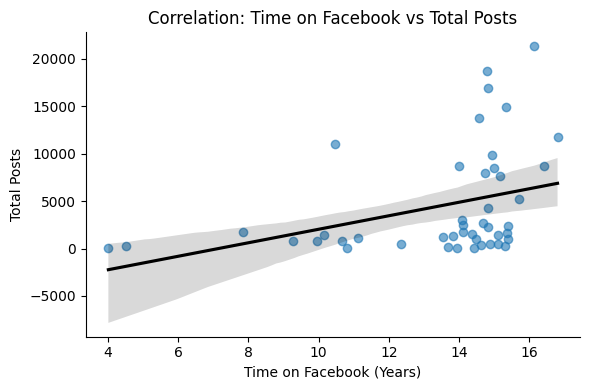

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# ------------------ Correlation Between Facebook Use Duration and Posting Volume ------------------

# Step 1: Prepare data for correlation analysis

# Select relevant columns and drop any rows with missing values
df_corr = participant_activity[['num_posts_overall', 'time_on_facebook']].dropna()
df_corr['time_on_facebook_years'] = df_corr['time_on_facebook'].dt.total_seconds() / (60 * 60 * 24 * 365.25)

# Step 2: Compute Pearson correlation
# Measures linear correlation between total number of posts and time on Facebook
pearson_r, pearson_p = pearsonr(df_corr['num_posts_overall'], df_corr['time_on_facebook_years'])
print(f"Pearson correlation: r = {pearson_r:.3f}, p = {pearson_p:.4f}")

# Step 3: Compute Spearman correlation
# Captures monotonic relationships (useful if relationship is non-linear)
spearman_r, spearman_p = spearmanr(df_corr['num_posts_overall'], df_corr['time_on_facebook_years'])
print(f"Spearman correlation: r = {spearman_r:.3f}, p = {spearman_p:.4f}")

# Step 4: Visualize the relationship
# Scatterplot with a regression line to show the trend between Facebook duration and post volume
plt.figure(figsize=(6, 4))
sns.regplot(
    data=df_corr,
    x='time_on_facebook_years',
    y='num_posts_overall',
    scatter_kws={'alpha': 0.6},   # Makes points semi-transparent
    line_kws={'color': 'black'}  # Regression line color
)
plt.xlabel('Time on Facebook (Years)', color='black')
plt.ylabel('Total Posts', color='black')
plt.title('Correlation: Time on Facebook vs Total Posts', color='black')
sns.despine()
plt.tight_layout()
plt.show()

# PD-related posts per participant

In [65]:
# --------------------------------------------
# Quantify PD-Relevant Posts per Participant
# --------------------------------------------

# Step 1: Create a DataFrame with all participant IDs
all_ids = pd.DataFrame({'participant_id': participants['record_id'].unique()})

# Step 2: Count PD-relevant posts per participant
# Includes posts flagged by either NB or manual label
post_counts = pd_posts.groupby('participant_id').size().reset_index(name='num_posts')

# Step 3: Merge PD post counts into participant_activity table
# Missing values imply zero PD-relevant posts
participant_activity = participant_activity.merge(post_counts, on='participant_id', how='left')
participant_activity['num_posts'] = participant_activity['num_posts'].fillna(0).astype(int)

# Step 4: Compute time on Facebook in years
participant_activity['time_on_facebook_years'] = (
    participant_activity['time_on_facebook'].dt.total_seconds() / (365.25 * 24 * 3600)
)

# Step 5: Calculate proportion of all posts that are PD-relevant
participant_activity['proportion_pd_posts'] = (
    participant_activity['num_posts'] / participant_activity['num_posts_overall']
)
# Handle divide-by-zero and missing values
participant_activity['proportion_pd_posts'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
participant_activity['proportion_pd_posts'] = participant_activity['proportion_pd_posts'].fillna(0)

# --------------------------------------------
# Label PD Posts as Pre- or Post-Diagnosis
# --------------------------------------------

# Ensure dx_date is in datetime format
participant_activity['dx_date'] = pd.to_datetime(participant_activity['dx_date'], errors='coerce')

# Merge diagnosis date into pd_posts
pd_posts = pd_posts.merge(
    participant_activity[['participant_id', 'dx_date']],
    on='participant_id',
    how='left'
)

# Classify each post as 'pre' or 'post' diagnosis
mask = pd.notna(pd_posts['timestamp']) & pd.notna(pd_posts['dx_date'])
pd_posts['phase'] = pd.NA
pd_posts.loc[mask, 'phase'] = pd_posts.loc[mask].apply(
    lambda row: 'pre' if row['timestamp'] < row['dx_date'] else 'post',
    axis=1
)

# Step 6: Count number of PD-relevant posts pre/post diagnosis
phase_post_counts = (
    pd_posts.groupby(['participant_id', 'phase'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'pre': 'num_posts_pre', 'post': 'num_posts_post'})
)

# Ensure all participants are included, even those with 0 PD posts
phase_post_counts = (
    participant_activity[['participant_id']]
    .merge(phase_post_counts, on='participant_id', how='left')
    .fillna(0)
)

# Convert to integers
phase_post_counts['num_posts_pre'] = phase_post_counts['num_posts_pre'].astype(int)
phase_post_counts['num_posts_post'] = phase_post_counts['num_posts_post'].astype(int)

# Step 7: Merge phase-level post counts back into participant data
participant_activity = participant_activity.merge(phase_post_counts, on='participant_id', how='left')

# --------------------------------------------
# Summary Statistics
# --------------------------------------------

avg_time = participant_activity['time_on_facebook_years'].mean()
std_time = participant_activity['time_on_facebook_years'].std()
avg_posts = participant_activity['num_posts'].mean()
std_posts = participant_activity['num_posts'].std()
avg_prop = participant_activity['proportion_pd_posts'].mean()
std_prop = participant_activity['proportion_pd_posts'].std()

print(f"Average time on Facebook: {avg_time:.2f} years (SD = {std_time:.2f})")
print(f"Average number of PD-relevant posts: {avg_posts:.2f} (SD = {std_posts:.2f})")
print(f"Proportion of PD-relevant posts: {avg_prop:.3f} (SD = {std_prop:.3f})")

Average time on Facebook: 13.46 years (SD = 2.84)
Average number of PD-relevant posts: 104.47 (SD = 176.13)
Proportion of PD-relevant posts: 0.032 (SD = 0.060)


# Summary Stats by Diagnosis Group

In [66]:
# --------------------------------------------
# PROPORTION OF PD-RELEVANT POSTS: PRE & POST DX
# --------------------------------------------

# Identify those who were on Facebook before diagnosis
participant_activity['was_on_fb_pre_dx'] = participant_activity['time_before_diagnosis'] > pd.Timedelta(0)

# Mask for valid pre-diagnosis data
pre_mask = (
    participant_activity['dx_date'].notna() &
    (participant_activity['time_before_diagnosis'] > pd.Timedelta(0))
)

# Mask for valid post-diagnosis data
post_mask = participant_activity['dx_date'].notna()

# Initialize columns
participant_activity['proportion_pd_posts_pre_dx'] = pd.NA
participant_activity['proportion_pd_posts_post_dx'] = pd.NA

# Assign proportions
participant_activity.loc[pre_mask, 'proportion_pd_posts_pre_dx'] = (
    participant_activity.loc[pre_mask, 'num_posts_pre'] /
    participant_activity.loc[pre_mask, 'num_posts_overall_pre']
)

participant_activity.loc[post_mask, 'proportion_pd_posts_post_dx'] = (
    participant_activity.loc[post_mask, 'num_posts_post'] /
    participant_activity.loc[post_mask, 'num_posts_overall_post']
)

# Handle division by zero or missing data
for col in ['proportion_pd_posts_pre_dx', 'proportion_pd_posts_post_dx']:
    participant_activity[col] = participant_activity[col].replace([float('inf'), -float('inf')], pd.NA)
    participant_activity[col] = participant_activity[col].fillna(0)

# --------------------------------------------
# Summary Function — with optional dx_date and FB time filters
# --------------------------------------------

def summarize_proportion(df: pd.DataFrame, column: str, require_dx_date: bool = False, require_fb_pre_dx: bool = False) -> pd.DataFrame:
    """
    Summarizes the proportion column by diagnosis group with:
    - N (non-missing values)
    - Mean ± SD
    - Min–Max range

    Parameters:
    - require_dx_date: filter to participants with diagnosis date
    - require_fb_pre_dx: filter to those with any time before diagnosis
    """
    if require_dx_date:
        df = df[df['dx_date'].notna()]
    
    if require_fb_pre_dx:
        df = df[df['time_before_diagnosis'] > pd.Timedelta(0)]

    summary = df.groupby('diagnosis_group').agg(
        N_valid=(column, lambda x: x.dropna().shape[0]),
        mean_val=(column, 'mean'),
        std_val=(column, 'std'),
        min_val=(column, 'min'),
        max_val=(column, 'max')
    ).reset_index()

    summary['summary'] = summary.apply(
        lambda row: f"{row['mean_val']:.3f} ± {row['std_val']:.3f}", axis=1
    )
    summary['range_str'] = summary.apply(
        lambda row: f"{row['min_val']:.3f}–{row['max_val']:.3f}", axis=1
    )
    return summary[['diagnosis_group', 'N_valid', 'summary', 'range_str']]

# --------------------------------------------
# Generate Summaries
# --------------------------------------------

# Overall — include everyone
overall = summarize_proportion(participant_activity, 'proportion_pd_posts')
overall.columns = ['Group', 'N', 'Proportion of PD-relevant Posts ± STD', 'Range']

# Pre-diagnosis — must have dx_date + pre-dx FB activity
pre_dx = summarize_proportion(
    participant_activity, 
    'proportion_pd_posts_pre_dx', 
    require_dx_date=True, 
    require_fb_pre_dx=True
)
pre_dx.columns = ['Group', 'N (Pre-Dx)', 'Proportion of PD-relevant Posts Pre-Dx ± STD', 'Pre-Dx Range']

# Post-diagnosis — must have dx_date
post_dx = summarize_proportion(
    participant_activity, 
    'proportion_pd_posts_post_dx', 
    require_dx_date=True
)
post_dx.columns = ['Group', 'N (Post-Dx)', 'Proportion of PD-relevant Posts Post-Dx ± STD', 'Post-Dx Range']

# --------------------------------------------
# Combine and Output Summary Table
# --------------------------------------------

summary_all = overall.merge(pre_dx, on='Group', how='outer').merge(post_dx, on='Group', how='outer')

# Desired row order
desired_order = [
    "Parkinson's disease", 
    "Essential Tremor", 
    "Post traumatic Parkinson's", 
    "Caregiver"
]
summary_all['Group'] = pd.Categorical(summary_all['Group'], categories=desired_order, ordered=True)
summary_all = summary_all.sort_values('Group')

# Output
print(summary_all)
summary_all.to_excel('summary_proportion-pd-relevant_full.xlsx', index=False)

                        Group   N Proportion of PD-relevant Posts ± STD  \
2         Parkinson's disease  29                         0.036 ± 0.066   
1            Essential Tremor   3                         0.008 ± 0.001   
3  Post traumatic Parkinson's   1                           0.051 ± nan   
0                   Caregiver  12                         0.026 ± 0.056   

         Range  N (Pre-Dx) Proportion of PD-relevant Posts Pre-Dx ± STD  \
2  0.000–0.328          26                                0.017 ± 0.026   
1  0.007–0.008           3                                0.010 ± 0.001   
3  0.051–0.051           1                                  0.093 ± nan   
0  0.001–0.200           7                                0.011 ± 0.011   

  Pre-Dx Range  N (Post-Dx) Proportion of PD-relevant Posts Post-Dx ± STD  \
2  0.000–0.125           29                                 0.040 ± 0.071   
1  0.009–0.011            3                                 0.007 ± 0.001   
3  0.093–0.093   

In [67]:
# --------------------------------------------
# ANALYSIS: PD-Relevant Posts EXCLUDING Exercise Content
# --------------------------------------------

# Step 1: Count PD-relevant posts (excluding exercise) per participant
num_posts_no_exercise = pd_posts_no_exercise.groupby('participant_id').size().reset_index(name='num_posts_no_exercise')

# Step 2: Merge counts into participant_activity and handle missing data
participant_activity = participant_activity.merge(num_posts_no_exercise, on='participant_id', how='left')
participant_activity['num_posts_no_exercise'] = participant_activity['num_posts_no_exercise'].fillna(0).astype(int)

# Step 3: Compute proportion of total posts that are PD-relevant (excluding exercise)
participant_activity['proportion_pd_posts_no_exercise'] = (
    participant_activity['num_posts_no_exercise'] / participant_activity['num_posts_overall']
)
participant_activity['proportion_pd_posts_no_exercise'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
participant_activity['proportion_pd_posts_no_exercise'] = participant_activity['proportion_pd_posts_no_exercise'].fillna(0)

# Step 4: Add dx_date to pd_posts_no_exercise and label posts by diagnosis phase
pd_posts_no_exercise = pd_posts_no_exercise.merge(
    participant_activity[['participant_id', 'dx_date']],
    on='participant_id',
    how='left'
)

# Assign each post as pre- or post-diagnosis
pd_posts_no_exercise['phase'] = pd.NA
mask = pd.notna(pd_posts_no_exercise['timestamp']) & pd.notna(pd_posts_no_exercise['dx_date'])
pd_posts_no_exercise.loc[mask, 'phase'] = pd_posts_no_exercise.loc[mask].apply(
    lambda row: 'pre' if row['timestamp'] < row['dx_date'] else 'post',
    axis=1
)

# Step 5: Count pre-/post-diagnosis PD posts per participant (excluding exercise)
# Only include participants with dx_date AND pre-dx Facebook activity
has_dx_and_pre = participant_activity[
    (participant_activity['dx_date'].notna()) &
    (participant_activity['time_before_diagnosis'] > pd.Timedelta(0))
][['participant_id']].drop_duplicates()

# Count posts by participant and phase
phase_counts = pd_posts_no_exercise.groupby(['participant_id', 'phase']).size().unstack(fill_value=0).reset_index()
phase_counts.rename(columns={'pre': 'num_posts_pre_no_exercise', 'post': 'num_posts_post_no_exercise'}, inplace=True)

# Merge into the filtered participant set
phase_post_counts_no_exercise = has_dx_and_pre.merge(phase_counts, on='participant_id', how='left')
phase_post_counts_no_exercise['num_posts_pre_no_exercise'] = phase_post_counts_no_exercise['num_posts_pre_no_exercise'].fillna(0).astype(int)
phase_post_counts_no_exercise['num_posts_post_no_exercise'] = phase_post_counts_no_exercise['num_posts_post_no_exercise'].fillna(0).astype(int)

# Merge these counts back into participant_activity
participant_activity = participant_activity.merge(phase_post_counts_no_exercise, on='participant_id', how='left')

# Fill missing with 0s for consistency
participant_activity['num_posts_pre_no_exercise'] = participant_activity['num_posts_pre_no_exercise'].fillna(0).astype(int)
participant_activity['num_posts_post_no_exercise'] = participant_activity['num_posts_post_no_exercise'].fillna(0).astype(int)

# Step 6: Compute proportions pre-/post-diagnosis
participant_activity['proportion_pd_posts_pre_dx_no_exercise'] = (
    participant_activity['num_posts_pre_no_exercise'] / participant_activity['num_posts_overall_pre']
)
participant_activity['proportion_pd_posts_post_dx_no_exercise'] = (
    participant_activity['num_posts_post_no_exercise'] / participant_activity['num_posts_overall_post']
)

# Clean up division issues
for col in ['proportion_pd_posts_pre_dx_no_exercise', 'proportion_pd_posts_post_dx_no_exercise']:
    participant_activity[col].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
    participant_activity[col] = participant_activity[col].fillna(0)

# Step 7: Print basic summary stats
print(f"Average number of PD-relevant posts (excluding exercise): {participant_activity['num_posts_no_exercise'].mean():.2f} (SD = {participant_activity['num_posts_no_exercise'].std():.2f})")
print(f"Proportion of PD-relevant posts (excluding exercise): {participant_activity['proportion_pd_posts_no_exercise'].mean():.3f} (SD = {participant_activity['proportion_pd_posts_no_exercise'].std():.3f})")

# Step 8: Generate Summary Tables by Group

# Overall
overall = summarize_proportion(participant_activity, 'proportion_pd_posts_no_exercise')
overall.columns = ['Group', 'N', 'Proportion of PD-relevant Posts ± STD', 'Range']

# Pre-Diagnosis — require dx_date and pre-dx Facebook time
pre_dx = summarize_proportion(
    participant_activity,
    'proportion_pd_posts_pre_dx_no_exercise',
    require_dx_date=True,
    require_fb_pre_dx=True
)
pre_dx.columns = ['Group', 'N (Pre-Dx)', 'Proportion of PD-relevant Posts Pre-Dx ± STD', 'Pre-Dx Range']

# Post-Diagnosis — require dx_date
post_dx = summarize_proportion(
    participant_activity,
    'proportion_pd_posts_post_dx_no_exercise',
    require_dx_date=True
)
post_dx.columns = ['Group', 'N (Post-Dx)', 'Proportion of PD-relevant Posts Post-Dx ± STD', 'Post-Dx Range']

# Combine summaries
summary_no_exercise = overall.merge(pre_dx, on='Group', how='outer').merge(post_dx, on='Group', how='outer')

# Reorder groups
desired_order = [
    "Parkinson's disease", 
    "Essential Tremor", 
    "Post traumatic Parkinson's", 
    "Caregiver"
]
summary_no_exercise['Group'] = pd.Categorical(summary_no_exercise['Group'], categories=desired_order, ordered=True)
summary_no_exercise = summary_no_exercise.sort_values('Group')

# Output
print(summary_no_exercise)
summary_no_exercise.to_excel('summary_proportion-pd-relevant_no-exercise_full.xlsx', index=False)

Average number of PD-relevant posts (excluding exercise): 67.71 (SD = 111.19)
Proportion of PD-relevant posts (excluding exercise): 0.020 (SD = 0.036)
                        Group   N Proportion of PD-relevant Posts ± STD  \
2         Parkinson's disease  29                         0.022 ± 0.036   
1            Essential Tremor   3                         0.005 ± 0.001   
3  Post traumatic Parkinson's   1                           0.036 ± nan   
0                   Caregiver  12                         0.017 ± 0.040   

         Range  N (Pre-Dx) Proportion of PD-relevant Posts Pre-Dx ± STD  \
2  0.000–0.157          26                                0.012 ± 0.025   
1  0.004–0.006           3                                0.002 ± 0.003   
3  0.036–0.036           1                                  0.003 ± nan   
0  0.000–0.143           7                                0.008 ± 0.010   

  Pre-Dx Range  N (Post-Dx) Proportion of PD-relevant Posts Post-Dx ± STD  \
2  0.000–0.125      

In [68]:
from scipy.stats import wilcoxon

# Filter for PD and Caregiver only
df = participant_activity[participant_activity['diagnosis_group'].isin(["Parkinson's disease", "Caregiver"])]

# -------------------------
# Parkinson’s Disease Group
# -------------------------
df_pd = df[df['diagnosis_group'] == "Parkinson's disease"]
pd_pre = df_pd['proportion_pd_posts_pre_dx']
pd_post = df_pd['proportion_pd_posts_post_dx']

# Remove cases with missing or no change
pd_mask = (pd_pre.notna() & pd_post.notna()) & (pd_pre != pd_post)
pd_pre_filtered = pd_pre[pd_mask]
pd_post_filtered = pd_post[pd_mask]

print("==== Parkinson's Disease Group ====")
print(f"Included N = {len(pd_pre_filtered)} participants with valid and differing pre/post proportions")
print("Comparing within-subject change in proportion of PD-related posts from pre- to post-diagnosis.")

# Wilcoxon test for PD group
stat_pd, pval_pd = wilcoxon(pd_pre_filtered, pd_post_filtered, alternative='two-sided')
print(f"Wilcoxon signed-rank test: W = {stat_pd}, p = {pval_pd:.4f}")
print()

# -------------------------
# Caregiver Group
# -------------------------
df_cg = df[df['diagnosis_group'] == "Caregiver"]
cg_pre = df_cg['proportion_pd_posts_pre_dx']
cg_post = df_cg['proportion_pd_posts_post_dx']

# Remove cases with missing or no change
cg_mask = (cg_pre.notna() & cg_post.notna()) & (cg_pre != cg_post)
cg_pre_filtered = cg_pre[cg_mask]
cg_post_filtered = cg_post[cg_mask]

print("==== Caregiver Group ====")
print(f"Included N = {len(cg_pre_filtered)} participants with valid and differing pre/post proportions")
print("Comparing within-subject change in proportion of PD-related posts before and after the associated participant's diagnosis.")

# Wilcoxon test for Caregiver group
stat_cg, pval_cg = wilcoxon(cg_pre_filtered, cg_post_filtered, alternative='two-sided')
print(f"Wilcoxon signed-rank test: W = {stat_cg}, p = {pval_cg:.4f}")

==== Parkinson's Disease Group ====
Included N = 27 participants with valid and differing pre/post proportions
Comparing within-subject change in proportion of PD-related posts from pre- to post-diagnosis.
Wilcoxon signed-rank test: W = 105.0, p = 0.0436

==== Caregiver Group ====
Included N = 9 participants with valid and differing pre/post proportions
Comparing within-subject change in proportion of PD-related posts before and after the associated participant's diagnosis.
Wilcoxon signed-rank test: W = 16.0, p = 0.4961


In [69]:
from scipy.stats import wilcoxon

# Filter for PD and Caregiver only
df = participant_activity[participant_activity['diagnosis_group'].isin(["Parkinson's disease", "Caregiver"])]

# -------------------------
# Parkinson’s Disease Group
# -------------------------
df_pd = df[df['diagnosis_group'] == "Parkinson's disease"]
pd_pre = df_pd['proportion_pd_posts_pre_dx_no_exercise']
pd_post = df_pd['proportion_pd_posts_post_dx_no_exercise']

# Remove cases with missing or no change
pd_mask = (pd_pre.notna() & pd_post.notna()) & (pd_pre != pd_post)
pd_pre_filtered = pd_pre[pd_mask]
pd_post_filtered = pd_post[pd_mask]

print("==== Parkinson's Disease Group (Excluding Exercise) ====")
print(f"Included N = {len(pd_pre_filtered)} participants with valid and differing pre/post proportions")
print("Comparing within-subject change in *non-exercise* PD-related post proportions from pre- to post-diagnosis.")

# Wilcoxon test for PD group
stat_pd, pval_pd = wilcoxon(pd_pre_filtered, pd_post_filtered, alternative='two-sided')
print(f"Wilcoxon signed-rank test: W = {stat_pd}, p = {pval_pd:.4f}")
print()

# -------------------------
# Caregiver Group
# -------------------------
df_cg = df[df['diagnosis_group'] == "Caregiver"]
cg_pre = df_cg['proportion_pd_posts_pre_dx_no_exercise']
cg_post = df_cg['proportion_pd_posts_post_dx_no_exercise']

# Remove cases with missing or no change
cg_mask = (cg_pre.notna() & cg_post.notna()) & (cg_pre != cg_post)
cg_pre_filtered = cg_pre[cg_mask]
cg_post_filtered = cg_post[cg_mask]

print("==== Caregiver Group (Excluding Exercise) ====")
print(f"Included N = {len(cg_pre_filtered)} participants with valid and differing pre/post proportions")
print("Comparing within-subject change in *non-exercise* PD-related post proportions before and after the associated participant's diagnosis.")

# Wilcoxon test for Caregiver group
stat_cg, pval_cg = wilcoxon(cg_pre_filtered, cg_post_filtered, alternative='two-sided')
print(f"Wilcoxon signed-rank test: W = {stat_cg}, p = {pval_cg:.4f}")

==== Parkinson's Disease Group (Excluding Exercise) ====
Included N = 24 participants with valid and differing pre/post proportions
Comparing within-subject change in *non-exercise* PD-related post proportions from pre- to post-diagnosis.
Wilcoxon signed-rank test: W = 83.0, p = 0.0564

==== Caregiver Group (Excluding Exercise) ====
Included N = 6 participants with valid and differing pre/post proportions
Comparing within-subject change in *non-exercise* PD-related post proportions before and after the associated participant's diagnosis.
Wilcoxon signed-rank test: W = 7.0, p = 0.5625


# PD v caregiver

In [70]:
import pandas as pd
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Filter for PD and Caregiver groups only
df = participant_activity[
    participant_activity['diagnosis_group'].isin(["Parkinson's disease", "Caregiver"])
]

# Keep only those with:
# - valid pre-dx PD proportion
# - nonzero time on Facebook before diagnosis
df = df[
    df['proportion_pd_posts_pre_dx'].notna() &
    (df['time_before_diagnosis'] > pd.Timedelta(0))
]

# Separate groups
pd_pre = df[df['diagnosis_group'] == "Parkinson's disease"]['proportion_pd_posts_pre_dx']
cg_pre = df[df['diagnosis_group'] == "Caregiver"]['proportion_pd_posts_pre_dx']

# Check normality
stat_pd, p_pd = shapiro(pd_pre)
stat_cg, p_cg = shapiro(cg_pre)

print("Shapiro-Wilk Normality Test:")
print(f"PD group: p = {p_pd:.4f}")
print(f"Caregiver group: p = {p_cg:.4f}")

# Decide between parametric and nonparametric test
if p_pd > 0.05 and p_cg > 0.05:
    # Use Welch's t-test
    stat, p_val = ttest_ind(pd_pre, cg_pre, equal_var=False)
    test_name = "Welch’s t-test"
    stat_label = "t"
else:
    # Use Mann-Whitney U test
    stat, p_val = mannwhitneyu(pd_pre, cg_pre, alternative='two-sided')
    test_name = "Mann-Whitney U test"
    stat_label = "U"

# Output results
print(f"\n{test_name} comparing PD vs. Caregiver pre-dx proportions:")
print(f"{stat_label} = {stat:.2f}, p = {p_val:.4f}")
print(f"N (PD) = {len(pd_pre)}, Mean = {pd_pre.mean():.3f}")
print(f"N (Caregiver) = {len(cg_pre)}, Mean = {cg_pre.mean():.3f}")

Shapiro-Wilk Normality Test:
PD group: p = 0.0000
Caregiver group: p = 0.3298

Mann-Whitney U test comparing PD vs. Caregiver pre-dx proportions:
U = 95.00, p = 0.8763
N (PD) = 26, Mean = 0.017
N (Caregiver) = 7, Mean = 0.011


In [71]:
import pandas as pd
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Filter for PD and Caregiver groups only
df = participant_activity[
    participant_activity['diagnosis_group'].isin(["Parkinson's disease", "Caregiver"])
]

# Keep only those with:
# - valid pre-dx PD proportion
# - nonzero time on Facebook before diagnosis
df = df[
    df['proportion_pd_posts_pre_dx_no_exercise'].notna() &
    (df['time_before_diagnosis'] > pd.Timedelta(0))
]

# Separate groups
pd_pre = df[df['diagnosis_group'] == "Parkinson's disease"]['proportion_pd_posts_pre_dx_no_exercise']
cg_pre = df[df['diagnosis_group'] == "Caregiver"]['proportion_pd_posts_pre_dx_no_exercise']

# Check normality
stat_pd, p_pd = shapiro(pd_pre)
stat_cg, p_cg = shapiro(cg_pre)

print("Shapiro-Wilk Normality Test:")
print(f"PD group: p = {p_pd:.4f}")
print(f"Caregiver group: p = {p_cg:.4f}")

# Decide between parametric and nonparametric test
if p_pd > 0.05 and p_cg > 0.05:
    # Use Welch's t-test
    stat, p_val = ttest_ind(pd_pre, cg_pre, equal_var=False)
    test_name = "Welch’s t-test"
    stat_label = "t"
else:
    # Use Mann-Whitney U test
    stat, p_val = mannwhitneyu(pd_pre, cg_pre, alternative='two-sided')
    test_name = "Mann-Whitney U test"
    stat_label = "U"

# Output results
print(f"\n{test_name} comparing PD vs. Caregiver pre-dx proportions No exercise:")
print(f"{stat_label} = {stat:.2f}, p = {p_val:.4f}")
print(f"N (PD) = {len(pd_pre)}, Mean = {pd_pre.mean():.3f}")
print(f"N (Caregiver) = {len(cg_pre)}, Mean = {cg_pre.mean():.3f}")

Shapiro-Wilk Normality Test:
PD group: p = 0.0000
Caregiver group: p = 0.0967

Mann-Whitney U test comparing PD vs. Caregiver pre-dx proportions No exercise:
U = 96.00, p = 0.8413
N (PD) = 26, Mean = 0.012
N (Caregiver) = 7, Mean = 0.008


In [72]:
import pandas as pd
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Filter for PD and Caregiver groups only
df = participant_activity[
    participant_activity['diagnosis_group'].isin(["Parkinson's disease", "Caregiver"])
]

# Keep only those with:
# - valid post-dx PD proportion
# - nonzero time on Facebook after diagnosis
df = df[
    df['proportion_pd_posts_post_dx'].notna() &
    (df['time_after_diagnosis'] > pd.Timedelta(0))
]

# Separate groups
pd_post = df[df['diagnosis_group'] == "Parkinson's disease"]['proportion_pd_posts_post_dx']
cg_post = df[df['diagnosis_group'] == "Caregiver"]['proportion_pd_posts_post_dx']

# Check normality
stat_pd, p_pd = shapiro(pd_post)
stat_cg, p_cg = shapiro(cg_post)

print("Shapiro-Wilk Normality Test:")
print(f"PD group: p = {p_pd:.4f}")
print(f"Caregiver group: p = {p_cg:.4f}")

# Decide between parametric and nonparametric test
if p_pd > 0.05 and p_cg > 0.05:
    # Use Welch's t-test
    stat, p_val = ttest_ind(pd_post, cg_post, equal_var=False)
    test_name = "Welch’s t-test"
    stat_label = "t"
else:
    # Use Mann-Whitney U test
    stat, p_val = mannwhitneyu(pd_post, cg_post, alternative='two-sided')
    test_name = "Mann-Whitney U test"
    stat_label = "U"

# Output results
print(f"\n{test_name} comparing PD vs. Caregiver post-dx proportions:")
print(f"{stat_label} = {stat:.2f}, p = {p_val:.4f}")
print(f"N (PD) = {len(pd_post)}, Mean = {pd_post.mean():.3f}")
print(f"N (Caregiver) = {len(cg_post)}, Mean = {cg_post.mean():.3f}")


Shapiro-Wilk Normality Test:
PD group: p = 0.0000
Caregiver group: p = 0.0060

Mann-Whitney U test comparing PD vs. Caregiver post-dx proportions:
U = 170.00, p = 0.1805
N (PD) = 29, Mean = 0.040
N (Caregiver) = 9, Mean = 0.010


In [73]:
import pandas as pd
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Filter for PD and Caregiver groups only
df = participant_activity[
    participant_activity['diagnosis_group'].isin(["Parkinson's disease", "Caregiver"])
]

# Keep only those with:
# - valid pre-dx PD proportion
# - nonzero time on Facebook after diagnosis
df = df[
    df['proportion_pd_posts_post_dx_no_exercise'].notna() &
    (df['time_after_diagnosis'] > pd.Timedelta(0))
]

# Separate groups
pd_post = df[df['diagnosis_group'] == "Parkinson's disease"]['proportion_pd_posts_post_dx_no_exercise']
cg_post = df[df['diagnosis_group'] == "Caregiver"]['proportion_pd_posts_post_dx_no_exercise']

# Check normality
stat_pd, p_pd = shapiro(pd_post)
stat_cg, p_cg = shapiro(cg_post)

print("Shapiro-Wilk Normality Test:")
print(f"PD group: p = {p_pd:.4f}")
print(f"Caregiver group: p = {p_cg:.4f}")

# Decide between parametric and nonparametric test
if p_pd > 0.05 and p_cg > 0.05:
    # Use Welch's t-test
    stat, p_val = ttest_ind(pd_post, cg_post, equal_var=False)
    test_name = "Welch’s t-test"
    stat_label = "t"
else:
    # Use Mann-Whitney U test
    stat, p_val = mannwhitneyu(pd_post, cg_post, alternative='two-sided')
    test_name = "Mann-Whitney U test"
    stat_label = "U"

# Output results
print(f"\n{test_name} comparing PD vs. Caregiver post-dx proportions No exercise:")
print(f"{stat_label} = {stat:.2f}, p = {p_val:.4f}")
print(f"N (PD) = {len(pd_post)}, Mean = {pd_post.mean():.3f}")
print(f"N (Caregiver) = {len(cg_post)}, Mean = {cg_post.mean():.3f}")

Shapiro-Wilk Normality Test:
PD group: p = 0.0000
Caregiver group: p = 0.0026

Mann-Whitney U test comparing PD vs. Caregiver post-dx proportions No exercise:
U = 180.50, p = 0.0877
N (PD) = 29, Mean = 0.022
N (Caregiver) = 9, Mean = 0.004


# Wordclouds

In [74]:
import pandas as pd
from nltk.stem import PorterStemmer

# Initialize the stemmer
stemmer = PorterStemmer()

# Sample DataFrame for illustration
# df['keywords'] is a column of comma-separated keywords like "danc, dance"
# First, ensure entries are lists of keywords
pd_posts['keywords'] = pd_posts['keywords'].fillna('').apply(lambda x: [kw.strip() for kw in x.split(',') if kw.strip()])

def remove_stem_duplicates(keyword_list):
    stems = {}
    cleaned_keywords = []
    
    for kw in keyword_list:
        stem = stemmer.stem(kw)
        # Keep the first encountered word for each stem
        if stem not in stems:
            stems[stem] = kw
            cleaned_keywords.append(kw)
        else:
            # If the existing keyword is shorter, keep it
            if len(kw) > len(stems[stem]):
                cleaned_keywords.remove(stems[stem])
                stems[stem] = kw
                cleaned_keywords.append(kw)
    return cleaned_keywords

# Apply to each row
pd_posts['keywords_cleaned'] = pd_posts['keywords'].apply(remove_stem_duplicates)

# Optionally, convert cleaned list back to a string
pd_posts['keywords_cleaned_str'] = pd_posts['keywords_cleaned'].apply(lambda x: ', '.join(x))

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
# Assuming participant metadata is in participant_activity
pd_posts = pd_posts.merge(
    participant_activity[['participant_id', 'diagnosis_group']],
    on='participant_id',
    how='left'
)

# Fill in missing dx_type as "Caregiver"
pd_posts['diagnosis_group'] = pd_posts['diagnosis_group'].fillna('Caregiver')

# Group by dx_type and concatenate clean text
grouped_text = pd_posts.groupby('diagnosis_group')['keywords_cleaned_str'].apply(lambda x: " ".join(x)).reset_index()

# Generate and display a word cloud for each diagnosis type
for _, row in grouped_text.iterrows():
    dx = row['diagnosis_group']
    text = row['keywords_cleaned_str']
    
    wordcloud = WordCloud(width=4000, height=2000, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {dx}')
    #plt.show()

    # Save the figure with 300 PPI
    filename = f'wordcloud_{dx}_overall.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close() # Close the plot to free up memory
    print(f"Saved {filename}")

Saved wordcloud_Caregiver_overall.png
Saved wordcloud_Essential Tremor_overall.png
Saved wordcloud_Parkinson's disease_overall.png
Saved wordcloud_Post traumatic Parkinson's_overall.png


In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Ensure diagnosis group is merged in
if 'diagnosis_group' not in pd_posts.columns:
    pd_posts = pd_posts.merge(
        participant_activity[['participant_id', 'diagnosis_group']],
        on='participant_id',
        how='left'
    )

# Fill in missing values
pd_posts['diagnosis_group'] = pd_posts['diagnosis_group'].fillna('Caregiver')
pd_posts['phase'] = pd_posts['phase'].fillna('unknown')
pd_posts['keywords_cleaned_str'] = pd_posts['keywords_cleaned_str'].fillna('')

# Group by diagnosis group and phase
grouped_text = pd_posts.groupby(['diagnosis_group', 'phase'])['keywords_cleaned_str'].apply(lambda x: " ".join(x)).reset_index()

# Generate word clouds
for _, row in grouped_text.iterrows():
    dx = row['diagnosis_group']
    phase = row['phase']
    text = row['keywords_cleaned_str']

    if not text.strip():
        continue  # Skip empty cases

    wordcloud = WordCloud(width=4000, height=2000, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud – {dx} ({phase.capitalize()} Diagnosis)')
    #plt.show()

    # Save the figure with 300 PPI
    filename = f'wordcloud_{dx.replace(" ", "_")}_{phase}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close() # Close the plot to free up memory
    print(f"Saved {filename}")

Saved wordcloud_Caregiver_post.png
Saved wordcloud_Caregiver_pre.png
Saved wordcloud_Caregiver_unknown.png
Saved wordcloud_Essential_Tremor_post.png
Saved wordcloud_Essential_Tremor_pre.png
Saved wordcloud_Parkinson's_disease_post.png
Saved wordcloud_Parkinson's_disease_pre.png
Saved wordcloud_Post_traumatic_Parkinson's_post.png
Saved wordcloud_Post_traumatic_Parkinson's_pre.png


In [134]:
from collections import Counter

# Prepare a list to hold the results
keyword_freq_by_group = []

# Loop through each group-phase combination
for (dx, phase), group in pd_posts.groupby(['diagnosis_group', 'phase']):
    # Concatenate all cleaned keywords for this group-phase
    all_keywords = ", ".join(group['keywords_cleaned_str'].dropna())
    
    # Split into individual keywords
    keyword_list = [kw.strip() for kw in all_keywords.split(",") if kw.strip()]
    
    # Count frequencies
    keyword_counts = Counter(keyword_list)
    
    # Get the most common 20 keywords
    top_keywords = keyword_counts.most_common(20)
    
    # Add to results
    keyword_freq_by_group.append({
        'diagnosis_group': dx,
        'phase': phase,
        'top_keywords': top_keywords
    })

# Convert to a DataFrame for easier viewing (explodes top keywords into rows)
freq_rows = []
for entry in keyword_freq_by_group:
    for word, count in entry['top_keywords']:
        freq_rows.append({
            'diagnosis_group': entry['diagnosis_group'],
            'phase': entry['phase'],
            'keyword': word,
            'count': count
        })

df_keyword_freq = pd.DataFrame(freq_rows)
df_keyword_freq.to_csv('df_keyword_freq.csv')

In [133]:
print(df_keyword_freq)

                diagnosis_group phase     keyword  count
0                     Caregiver  post   parkinson    144
1                     Caregiver  post        help     94
2                     Caregiver  post        walk     73
3                     Caregiver  post  foundation     73
4                     Caregiver  post      diseas     68
..                          ...   ...         ...    ...
154  Post traumatic Parkinson's   pre        seat      1
155  Post traumatic Parkinson's   pre         bed      1
156  Post traumatic Parkinson's   pre         ski      1
157  Post traumatic Parkinson's   pre          5k      1
158  Post traumatic Parkinson's   pre     running      1

[159 rows x 4 columns]


In [ ]:


# Define known participant counts
total_participants = 45  # Known participants with Facebook data
pd_participants = 29  # Known participants with PD

# Merge participant data into posts
participants["participant_id"] = participants["record_id"]
posts = posts.merge(
    participants[["participant_id", "gender", "pd_yesno", "dx_type", "diagnosis_date"]],
    on="participant_id",
    how="inner",  # Use 'inner' to ensure only participants found in posts are retained
)



Loading data from REDCap reports...


In [2]:
# Ensure timestamp and diagnosis_date are in datetime format
posts["timestamp"] = pd.to_datetime(posts["timestamp"], errors='coerce')
posts["diagnosis_date"] = pd.to_datetime(posts["diagnosis_date"], errors='coerce')

# Detect explicit mentions of PD
posts["explicit_mention_pd"] = posts["text"].str.contains(r"parkinson|(?<!\w)pd(?!\w)", case=False, na=False)

# Ensure we only use participants who actually have posts
participants_with_posts = posts["participant_id"].unique()
participants_with_pd_posts = posts[posts["dx_type"] == "Parkinson's disease"]["participant_id"].unique()

# Filter PD-related posts
pd_posts = posts[(posts["nb_classification"] == 1) | (posts["manual_label_pd_relevant"] == 1)]
print(f"Identified {len(pd_posts)} posts classified as PD-relevant.")

# **Compute necessary metrics**

# **Total PD-related posts**
total_pd_posts = len(pd_posts)
print(f"Total PD-relevant posts: {total_pd_posts}")
print(f"Total number of participants with PD-relevant posts: {pd_posts['participant_id'].nunique()}")

# **Average number of PD-related posts per participant (including zeroes)**
pd_post_counts = pd_posts.groupby("participant_id").size()
pd_post_counts = pd_post_counts.reindex(participants_with_posts, fill_value=0)  # Only use participants with posts

avg_pd_posts_per_participant = pd_post_counts.mean()
std_pd_posts_per_participant = pd_post_counts.std()
print(f"Average number of PD-relevant posts per participant: {avg_pd_posts_per_participant:.2f} ± {std_pd_posts_per_participant:.2f}")


# **Percentage of participants with at least one PD-related post**
participants_with_pd_post = (pd_post_counts > 0).sum()
percent_with_pd_post = (participants_with_pd_post / total_participants) * 100
print(f"{percent_with_pd_post:.2f}% of participants have at least one PD-relevant post.")

# **Percentage of participants explicitly referencing PD at least once**
explicit_pd_mentions = posts.groupby("participant_id")["explicit_mention_pd"].any().sum()
percent_explicit_pd = (explicit_pd_mentions / total_participants) * 100
print(f"{percent_explicit_pd:.2f}% of participants explicitly mentioned PD in at least one post.")

# **Statistics for individuals with PD**
pd_post_counts_pd = pd_posts[pd_posts["dx_type"] == "Parkinson's disease"].groupby("participant_id").size()
pd_post_counts_pd = pd_post_counts_pd.reindex(participants_with_pd_posts, fill_value=0)

avg_pd_posts_pd = pd_post_counts_pd.mean()
std_pd_posts_pd = pd_post_counts_pd.std()
print(f"Participants with PD made an average of {avg_pd_posts_pd:.2f} ± {std_pd_posts_pd:.2f} PD-relevant posts.")

# **Compute number of posts before and after diagnosis**
posts_before_diagnosis = pd_posts[pd_posts["timestamp"] < pd_posts["diagnosis_date"]].groupby("participant_id").size()
posts_after_diagnosis = pd_posts[pd_posts["timestamp"] >= pd_posts["diagnosis_date"]].groupby("participant_id").size()

# Ensure all PD participants are represented
posts_before_diagnosis = posts_before_diagnosis.reindex(participants_with_pd_posts, fill_value=0)
posts_after_diagnosis = posts_after_diagnosis.reindex(participants_with_pd_posts, fill_value=0)

# **Compute means and standard deviations**
avg_posts_before_dx = posts_before_diagnosis.mean()
std_posts_before_dx = posts_before_diagnosis.std()

avg_posts_after_dx = posts_after_diagnosis.mean()
std_posts_after_dx = posts_after_diagnosis.std()
print(f"Before diagnosis, participants made {avg_posts_before_dx:.2f} ± {std_posts_before_dx:.2f} PD-relevant posts.")
print(f"After diagnosis, participants made {avg_posts_after_dx:.2f} ± {std_posts_after_dx:.2f} PD-relevant posts.")

# **Percentage of individuals with PD explicitly mentioning PD**
explicit_pd_mentions_pd = posts[(posts["explicit_mention_pd"]) & (posts["dx_type"] == "Parkinson's disease")]["participant_id"].nunique()
percent_explicit_pd_pd = (explicit_pd_mentions_pd / pd_participants) * 100
print(f"{percent_explicit_pd_pd:.2f}% of individuals with PD explicitly mentioned PD.")

# **Percentage of individuals with PD with at least one PD-relevant post**
participants_with_pd_relevant_post = (pd_post_counts_pd > 0).sum()
percent_with_pd_relevant_post = (participants_with_pd_relevant_post / pd_participants) * 100
print(f"{percent_with_pd_relevant_post:.2f}% of individuals with PD had at least one PD-relevant post.")

# **Store results in a dictionary**
results = {
    "Total PD-related posts": total_pd_posts,
    "Average PD posts per participant": avg_pd_posts_per_participant,
    "SD PD posts per participant": std_pd_posts_per_participant,
    "% of participants with at least one PD-relevant post": percent_with_pd_post,
    "% of participants explicitly mentioning PD": percent_explicit_pd,
    "Average PD posts per participant with PD": avg_pd_posts_pd,
    "SD PD posts per participant with PD": std_pd_posts_pd,
    "Average posts before diagnosis": avg_posts_before_dx,
    "SD posts before diagnosis": std_posts_before_dx,
    "Average posts after diagnosis": avg_posts_after_dx,
    "SD posts after diagnosis": std_posts_after_dx,
    "% of individuals with PD explicitly mentioning PD": percent_explicit_pd_pd,
    "% of individuals with PD with at least one PD-relevant post": percent_with_pd_relevant_post,
}

# **Display results as a DataFrame**
results_df = pd.DataFrame(results.items(), columns=["Metric", "Value"])

Identified 4701 posts classified as PD-relevant.
Total PD-relevant posts: 4701
Total number of participants with PD-relevant posts: 43
Average number of PD-relevant posts per participant: 104.47 ± 176.13
95.56% of participants have at least one PD-relevant post.
66.67% of participants explicitly mentioned PD in at least one post.
Participants with PD made an average of 99.21 ± 171.96 PD-relevant posts.
Before diagnosis, participants made 24.34 ± 58.36 PD-relevant posts.
After diagnosis, participants made 74.86 ± 156.02 PD-relevant posts.
68.97% of individuals with PD explicitly mentioned PD.
93.10% of individuals with PD had at least one PD-relevant post.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeannepowell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


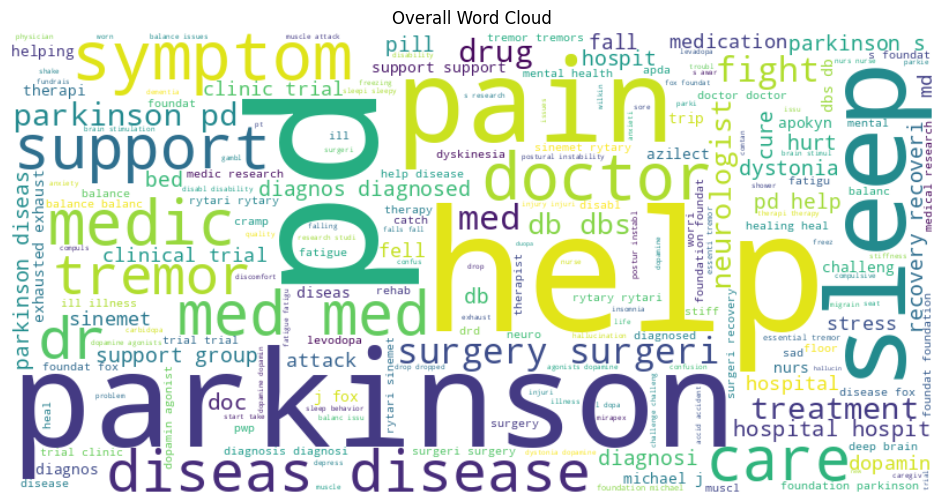

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

# Download stopwords if not already available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # Remove punctuation and numbers
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Clean the text column
pd_posts['clean_text'] = pd_posts['text'].apply(preprocess_text)

# If you want a single word cloud across all posts:
all_text = " ".join(pd_posts['keywords'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Overall Word Cloud')
plt.show()



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeannepowell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/sh/lc5_37517m91tb6hr1ssqz7c0000gn/T/ipykernel_64481/3119031028.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_posts["timestamp"] = pd.to_datetime(pd_posts["timestamp"], errors='coerce')
/var/folders/sh/lc5_37517m91tb6hr1ssqz7c0000gn/T/ipykernel_64481/3119031028.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_posts["diagnosis_date"]

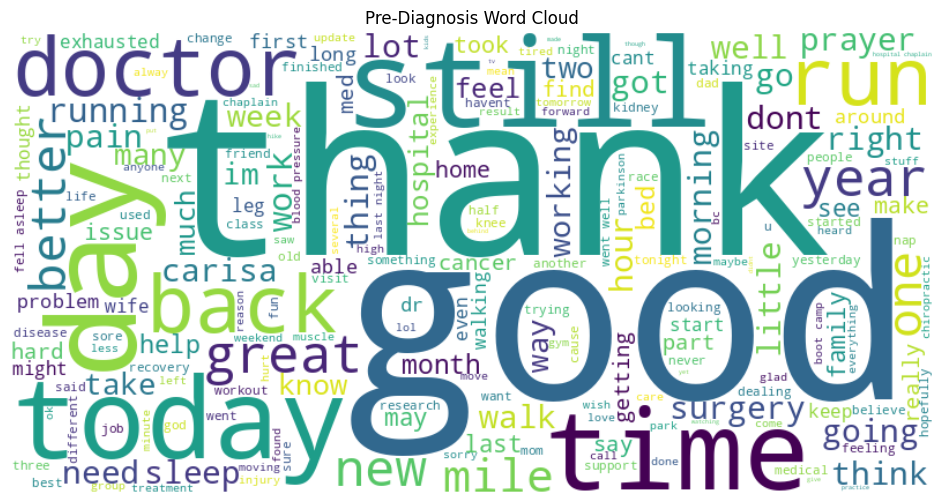

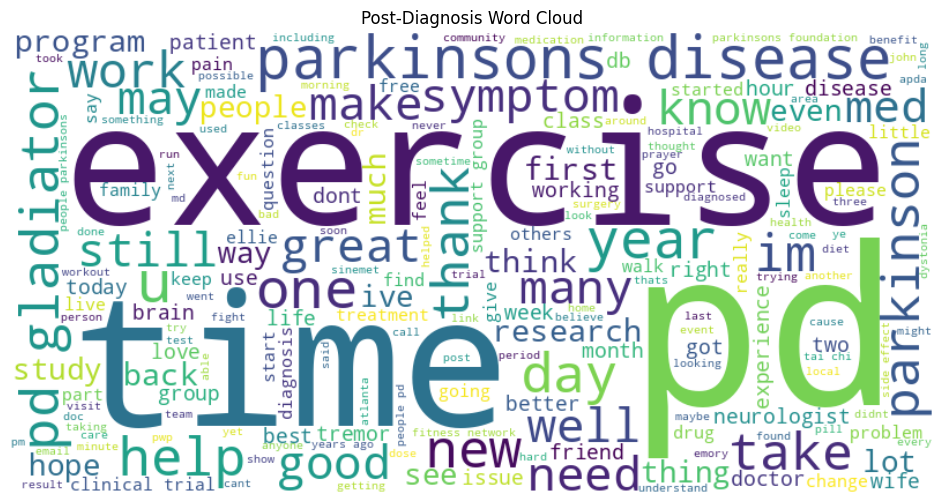

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import re

# Download stopwords if needed
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # Remove punctuation and numbers
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Ensure datetime format
pd_posts["timestamp"] = pd.to_datetime(pd_posts["timestamp"], errors='coerce')
pd_posts["diagnosis_date"] = pd.to_datetime(pd_posts["diagnosis_date"], errors='coerce')

# Subset pre- and post-dx posts
pre_dx_posts = pd_posts[pd_posts["timestamp"] < pd_posts["diagnosis_date"]]
post_dx_posts = pd_posts[pd_posts["timestamp"] >= pd_posts["diagnosis_date"]]

# Optional: limit to PD participants only
pre_dx_posts = pre_dx_posts[pre_dx_posts["participant_id"].isin(participants_with_pd_posts)]
post_dx_posts = post_dx_posts[post_dx_posts["participant_id"].isin(participants_with_pd_posts)]

# Clean the text
pre_dx_posts["clean_text"] = pre_dx_posts["text"].apply(preprocess_text)
post_dx_posts["clean_text"] = post_dx_posts["text"].apply(preprocess_text)

# Concatenate all text
pre_dx_text = " ".join(pre_dx_posts["clean_text"])
post_dx_text = " ".join(post_dx_posts["clean_text"])

# Create and display word clouds
for label, text in [("Pre-Diagnosis", pre_dx_text), ("Post-Diagnosis", post_dx_text)]:
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{label} Word Cloud")
    plt.show()


In [44]:
import pandas as pd

# Ensure timestamp and diagnosis_date are in datetime format
posts["timestamp"] = pd.to_datetime(posts["timestamp"], errors='coerce')
posts["diagnosis_date"] = pd.to_datetime(posts["diagnosis_date"], errors='coerce')

# Detect explicit mentions of PD
posts["explicit_mention_pd"] = posts["text"].str.contains(r"parkinson|(?<!\w)pd(?!\w)", case=False, na=False)

# Ensure we only use participants who actually have posts
participants_with_posts = posts["participant_id"].unique()
participants_with_pd_posts = posts[posts["dx_type"] == "Parkinson's disease"]["participant_id"].unique()

# **Filter out exercise-related posts**
posts = posts[~posts["keyword_categories"].str.contains("exercise", case=False, na=False)]
print(f"Filtered out exercise-related posts. Remaining posts: {len(posts)}")

# **Filter PD-related posts**
pd_posts = posts[(posts["nb_classification"] == 1) | (posts["manual_label_pd_relevant"] == 1)]
print(f"Identified {len(pd_posts)} posts classified as PD-relevant (excluding exercise).")

# **Compute necessary metrics**

# **Total PD-related posts**
total_pd_posts = len(pd_posts)
print(f"Total PD-relevant posts (excluding exercise): {total_pd_posts}")
print(f"Total number of participants with PD-relevant posts: {pd_posts['participant_id'].nunique()}")

# **Average number of PD-related posts per participant (including zeroes)**
pd_post_counts = pd_posts.groupby("participant_id").size()
pd_post_counts = pd_post_counts.reindex(participants_with_posts, fill_value=0)  # Only use participants with posts

avg_pd_posts_per_participant = pd_post_counts.mean()
std_pd_posts_per_participant = pd_post_counts.std()
print(f"Average number of PD-relevant posts per participant (excluding exercise): {avg_pd_posts_per_participant:.2f} ± {std_pd_posts_per_participant:.2f}")

# **Percentage of participants with at least one PD-related post**
participants_with_pd_post = (pd_post_counts > 0).sum()
percent_with_pd_post = (participants_with_pd_post / total_participants) * 100
print(f"{percent_with_pd_post:.2f}% of participants have at least one PD-relevant post (excluding exercise).")

# **Percentage of participants explicitly referencing PD at least once**
explicit_pd_mentions = posts.groupby("participant_id")["explicit_mention_pd"].any().sum()
percent_explicit_pd = (explicit_pd_mentions / total_participants) * 100
print(f"{percent_explicit_pd:.2f}% of participants explicitly mentioned PD in at least one post (excluding exercise).")

# **Statistics for individuals with PD**
pd_post_counts_pd = pd_posts[pd_posts["dx_type"] == "Parkinson's disease"].groupby("participant_id").size()
pd_post_counts_pd = pd_post_counts_pd.reindex(participants_with_pd_posts, fill_value=0)

avg_pd_posts_pd = pd_post_counts_pd.mean()
std_pd_posts_pd = pd_post_counts_pd.std()
print(f"Participants with PD made an average of {avg_pd_posts_pd:.2f} ± {std_pd_posts_pd:.2f} PD-relevant posts (excluding exercise).")

# **Compute number of posts before and after diagnosis**
posts_before_diagnosis = pd_posts[pd_posts["timestamp"] < pd_posts["diagnosis_date"]].groupby("participant_id").size()
posts_after_diagnosis = pd_posts[pd_posts["timestamp"] >= pd_posts["diagnosis_date"]].groupby("participant_id").size()

# Ensure all PD participants are represented
posts_before_diagnosis = posts_before_diagnosis.reindex(participants_with_pd_posts, fill_value=0)
posts_after_diagnosis = posts_after_diagnosis.reindex(participants_with_pd_posts, fill_value=0)

# **Compute means and standard deviations**
avg_posts_before_dx = posts_before_diagnosis.mean()
std_posts_before_dx = posts_before_diagnosis.std()

avg_posts_after_dx = posts_after_diagnosis.mean()
std_posts_after_dx = posts_after_diagnosis.std()
print(f"Before diagnosis, participants made {avg_posts_before_dx:.2f} ± {std_posts_before_dx:.2f} PD-relevant posts (excluding exercise).")
print(f"After diagnosis, participants made {avg_posts_after_dx:.2f} ± {std_posts_after_dx:.2f} PD-relevant posts (excluding exercise).")

# **Percentage of individuals with PD explicitly mentioning PD**
explicit_pd_mentions_pd = posts[(posts["explicit_mention_pd"]) & (posts["dx_type"] == "Parkinson's disease")]["participant_id"].nunique()
percent_explicit_pd_pd = (explicit_pd_mentions_pd / pd_participants) * 100
print(f"{percent_explicit_pd_pd:.2f}% of individuals with PD explicitly mentioned PD (excluding exercise).")

# **Percentage of individuals with PD with at least one PD-relevant post**
participants_with_pd_relevant_post = (pd_post_counts_pd > 0).sum()
percent_with_pd_relevant_post = (participants_with_pd_relevant_post / pd_participants) * 100
print(f"{percent_with_pd_relevant_post:.2f}% of individuals with PD had at least one PD-relevant post (excluding exercise).")

# **Store results in a dictionary**
results = {
    "Total PD-related posts (excluding exercise)": total_pd_posts,
    "Average PD posts per participant (excluding exercise)": avg_pd_posts_per_participant,
    "SD PD posts per participant (excluding exercise)": std_pd_posts_per_participant,
    "% of participants with at least one PD-relevant post (excluding exercise)": percent_with_pd_post,
    "% of participants explicitly mentioning PD (excluding exercise)": percent_explicit_pd,
    "Average PD posts per participant with PD (excluding exercise)": avg_pd_posts_pd,
    "SD PD posts per participant with PD (excluding exercise)": std_pd_posts_pd,
    "Average posts before diagnosis (excluding exercise)": avg_posts_before_dx,
    "SD posts before diagnosis (excluding exercise)": std_posts_before_dx,
    "Average posts after diagnosis (excluding exercise)": avg_posts_after_dx,
    "SD posts after diagnosis (excluding exercise)": std_posts_after_dx,
    "% of individuals with PD explicitly mentioning PD (excluding exercise)": percent_explicit_pd_pd,
    "% of individuals with PD with at least one PD-relevant post (excluding exercise)": percent_with_pd_relevant_post,
}

# **Display results as a DataFrame**
results_df = pd.DataFrame(results.items(), columns=["Metric", "Value"])

Filtered out exercise-related posts. Remaining posts: 15346
Identified 3047 posts classified as PD-relevant (excluding exercise).
Total PD-relevant posts (excluding exercise): 3047
Total number of participants with PD-relevant posts: 42
Average number of PD-relevant posts per participant (excluding exercise): 67.71 ± 111.19
93.33% of participants have at least one PD-relevant post (excluding exercise).
64.44% of participants explicitly mentioned PD in at least one post (excluding exercise).
Participants with PD made an average of 63.86 ± 100.85 PD-relevant posts (excluding exercise).
Before diagnosis, participants made 15.10 ± 34.41 PD-relevant posts (excluding exercise).
After diagnosis, participants made 48.76 ± 89.44 PD-relevant posts (excluding exercise).
68.97% of individuals with PD explicitly mentioned PD (excluding exercise).
93.10% of individuals with PD had at least one PD-relevant post (excluding exercise).


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeannepowell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


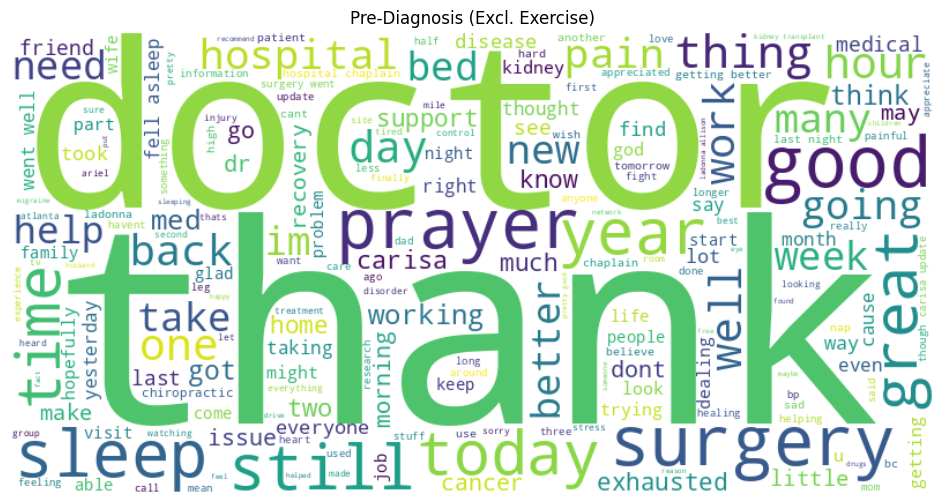

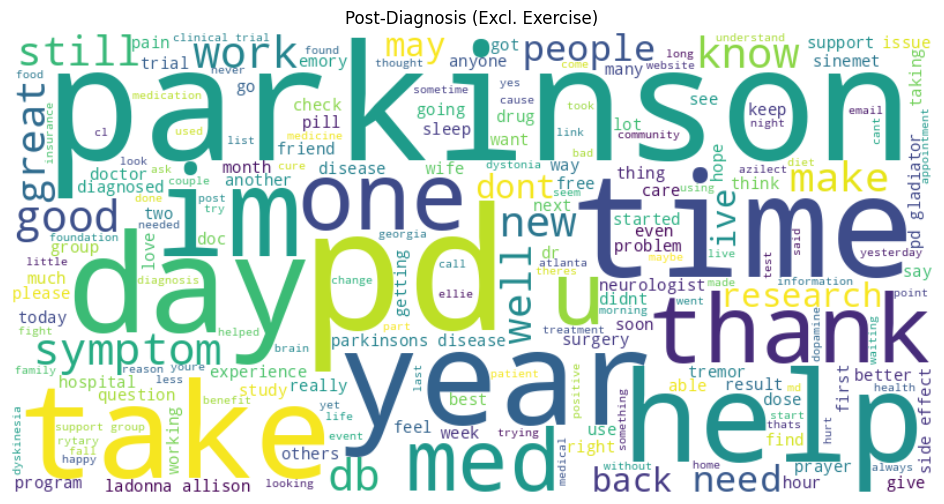

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import re

# Download stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Text cleaning function
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # Remove punctuation and numbers
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

# Ensure datetime format
pd_posts["timestamp"] = pd.to_datetime(pd_posts["timestamp"], errors='coerce')
pd_posts["diagnosis_date"] = pd.to_datetime(pd_posts["diagnosis_date"], errors='coerce')

pd_posts = pd_posts[~pd_posts["keyword_categories"].str.contains("exercise", case=False, na=False)]

# Filter for PD participants
pd_posts = pd_posts[pd_posts["participant_id"].isin(participants_with_pd_posts)]

# Subset pre- and post-diagnosis
pre_dx_posts = pd_posts[pd_posts["timestamp"] < pd_posts["diagnosis_date"]].copy()
post_dx_posts = pd_posts[pd_posts["timestamp"] >= pd_posts["diagnosis_date"]].copy()

# Clean the text
pre_dx_posts["clean_text"] = pre_dx_posts["text"].apply(preprocess_text)
post_dx_posts["clean_text"] = post_dx_posts["text"].apply(preprocess_text)

# Combine into a single string for word cloud generation
pre_dx_text = " ".join(pre_dx_posts["clean_text"])
post_dx_text = " ".join(post_dx_posts["clean_text"])

# Generate and display word clouds
for label, text in [("Pre-Diagnosis (Excl. Exercise)", pre_dx_text),
                    ("Post-Diagnosis (Excl. Exercise)", post_dx_text)]:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(label)
    plt.show()
